## Imports

In [26]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from math import ceil
import scipy

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import backend as K

%matplotlib inline  

# Defining Paths

In [2]:
path = os.getcwd()
img_width, img_height = 224, 224

train_data_dir = os.path.join(path, r'..\Data\train')
val_data_dir = os.path.join(path, r'..\Data\validation')
test_data_dir = os.path.join(path, r'..\Data\test')

batch_size = 8

# Creating Data Generators

In [22]:
train_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.2, 
                                   rotation_range=20, zoom_range=0.1, 
                                   width_shift_range=0.2, height_shift_range=0.2, 
                                   shear_range=0.1, horizontal_flip=True, fill_mode="nearest")

val_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
   train_data_dir,
   target_size=(img_height, img_width),
   batch_size=batch_size,
   class_mode='categorical')

val_generator = test_datagen.flow_from_directory(
   val_data_dir,
   target_size=(img_height, img_width),
   batch_size=batch_size,
   class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
   test_data_dir,
   target_size=(img_height, img_width),
   batch_size=batch_size,
   class_mode='categorical')

Found 233 images belonging to 3 classes.
Found 55 images belonging to 3 classes.
Found 25 images belonging to 3 classes.


# Load and compile pretrained Model

In [4]:
model_res50 = applications.ResNet50(weights='imagenet', include_top=False) 
model_vgg16 = applications.VGG16(weights='imagenet', include_top=False)

In [5]:
# add a global spatial average pooling layer
#x = model_res50.output
x = model_vgg16.output
x = GlobalAveragePooling2D()(x)

# add a flatten layer
x = Flatten()(x)

# and a fully connected output/classification layer
predictions = Dense(3, activation='softmax')(x)

# create the full network so we can train on it
#model_transfer = Model(inputs=model_res50.input, outputs=predictions)
model_transfer = Model(inputs=model_vgg16.input, outputs=predictions)

In [6]:
# compile
model_transfer.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(learning_rate=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [23]:
history_pretrained = model_transfer.fit(train_generator, epochs=20, shuffle = True, verbose = 1, validation_data = val_generator)

Epoch 1/20
30/30 [==============================] - 166s 5s/step - loss: 0.3607 - accuracy: 0.8841 - val_loss: 0.3383 - val_accuracy: 0.8545
Epoch 2/20
30/30 [==============================] - 155s 5s/step - loss: 0.1265 - accuracy: 0.9700 - val_loss: 0.2707 - val_accuracy: 0.8909
Epoch 3/20
30/30 [==============================] - 172s 6s/step - loss: 0.1348 - accuracy: 0.9571 - val_loss: 0.2411 - val_accuracy: 0.9273
Epoch 4/20
30/30 [==============================] - 195s 7s/step - loss: 0.0651 - accuracy: 0.9914 - val_loss: 0.5456 - val_accuracy: 0.8000
Epoch 5/20
30/30 [==============================] - 197s 7s/step - loss: 0.1653 - accuracy: 0.9442 - val_loss: 0.3432 - val_accuracy: 0.8727
Epoch 6/20
30/30 [==============================] - 198s 7s/step - loss: 0.0712 - accuracy: 0.9871 - val_loss: 0.3007 - val_accuracy: 0.8727
Epoch 7/20
30/30 [==============================] - 197s 7s/step - loss: 0.0704 - accuracy: 0.9785 - val_loss: 0.2262 - val_accuracy: 0.8727
Epoch 8/20
30

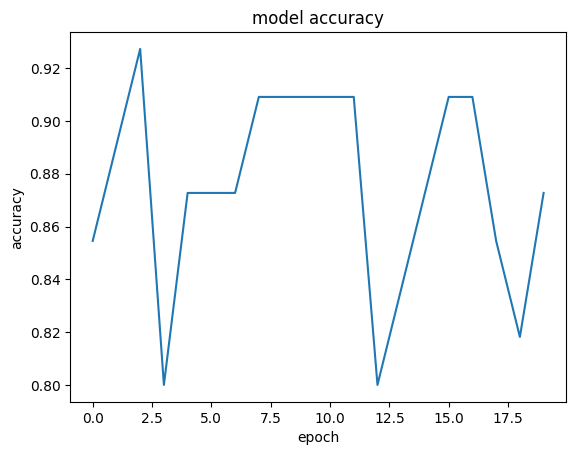

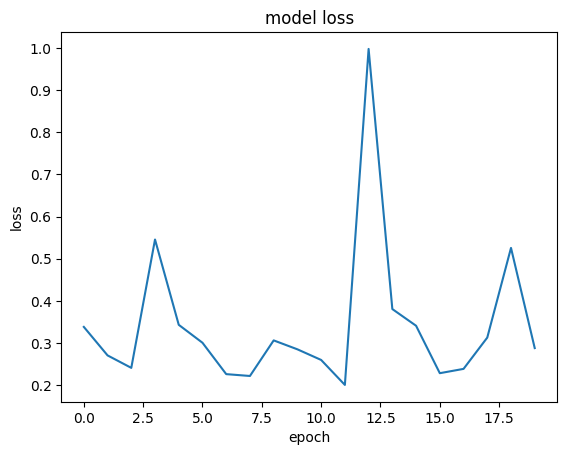

In [27]:
# summarize history for accuracy
plt.plot(history_pretrained.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

# summarize history for loss
plt.plot(history_pretrained.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [29]:
model_transfer.evaluate(test_generator)

4/4 [==============================] - 9s 2s/step - loss: 0.7780 - accuracy: 0.7200


[0.7779837846755981, 0.7200000286102295]

# Saving Model

In [28]:
model_path = './../Trained_Model/model_vgg.h5'
model_transfer.save(model_path)